In [1]:
import torch
import numpy as np
import pandas as pd
import helper_functions as hf
from dataloader import JPXData
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from statistics import mean

torch.set_printoptions(profile="default")
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/aymane/Kaggle/jpx-2022/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Run this to create the new modified_data folder
# ~ 1 min runtime

# hf.concat_data()

# Run this to tokenize Section/Product and NewMarketSegmentColumns on stock_list.csv
# ~ 20 secs runtime

# hf.tokenize_stock_list()

# Run this to adjust the closing price
# ~ 40 secs runtime

# hf.adjust_price()

In [4]:
dataloader = JPXData()
trainloader = torch.utils.data.DataLoader(dataloader, batch_size=1, shuffle=True, num_workers=5)

In [5]:
# Ranking Securities Codes by rate of change from t+1 to t+2
stock_prices = pd.read_csv("modified_data/stock_prices.csv")
date = "2017-01-04"
targets = stock_prices.query("Date == @date")[["Target", "SecuritiesCode"]].fillna(0)
df = targets.sort_values(by="Target")
df

,Target,SecuritiesCode
1733,-0.069874,9474
1856,-0.067387,9983
1136,-0.062112,6875
1852,-0.059276,9974
1078,-0.057514,6707
...,...,...
1695,0.094378,9233
404,0.098553,3547
1000,0.104668,6425
1297,0.106332,7600


In [6]:
a = dataloader[0]
print(a)

(tensor([-0.9104, -0.1097,  0.3713,  ...,  0.6076, -1.2079, -0.6935]), tensor([ 0.0730,  1.2324,  0.6154,  ...,  1.5042, -0.1132,  0.7481]))


In [7]:
# # Verifying if the ranking is the same
# securities_codes    = stock_prices["SecuritiesCode"]
# securities_list     = sorted(list(set(securities_codes)))
# securities_dict     = {i: securities_list.index(i) for i in securities_list}

# a = dataloader[0][1]
# sorted_args = torch.argsort(a, descending=True)
# securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]
# print(securities_sort)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2000, 2500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(2500, 1500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1500, 1000),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1000, 1500),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(1500, 2000),
        )

    def forward(self, x):
        output = self.layer_stack(x)
        return output

In [9]:
net = Net().cuda()

In [10]:
criterion = nn.MSELoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

In [11]:
loss_a1 = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(net.parameters(), 1.5)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_a1.append(running_loss)
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.10f}')
            running_loss = 0.0
        # torch.save(net.state_dict(), f'saved_models/{epoch}.pt')

print('Finished Training')

[1,   100] loss: 0.2867685571
[1,   200] loss: 0.2759694336
[1,   300] loss: 0.2419889944
[1,   400] loss: 0.2728369980
[1,   500] loss: 0.2488195317
[1,   600] loss: 0.2882900132
[1,   700] loss: 0.2734945832
[1,   800] loss: 0.2900326433
[1,   900] loss: 0.2878219385
[1,  1000] loss: 0.2437325935
[1,  1100] loss: 0.2673348589
[1,  1200] loss: 0.2601710298
[2,   100] loss: 0.2626914275
[2,   200] loss: 0.2345157551
[2,   300] loss: 0.2683971457
[2,   400] loss: 0.2856037509
[2,   500] loss: 0.2866707200
[2,   600] loss: 0.2665348704
[2,   700] loss: 0.2765933859
[2,   800] loss: 0.2764844543
[2,   900] loss: 0.2423477994
[2,  1000] loss: 0.2654607942
[2,  1100] loss: 0.2285056388
[2,  1200] loss: 0.2971078086
Finished Training


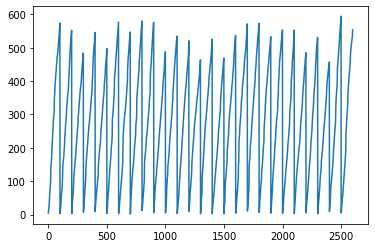

In [12]:
plt.plot(loss_a1)
plt.show()

In [13]:
# Verifying if the ranking is the same
securities_codes    = stock_prices["SecuritiesCode"]
securities_list     = sorted(list(set(securities_codes)))
securities_dict     = {i: securities_list.index(i) for i in securities_list}
submission = pd.DataFrame()
dates = sorted(list(set(pd.to_datetime(stock_prices["Date"]).dt.date)))

a = dataloader[0][1]
sorted_args = torch.argsort(a, descending=True)
securities_sort = [list(securities_dict.keys())[list(securities_dict.values()).index(i)] for i in sorted_args]


In [17]:
date = dates[0]
submission["Date"] = date.strftime("%Y-%m-%d")
submission["SecuritiesCode"] = securities_sort
submission["Rank"] = list(range(len(securities_sort)))

In [18]:
print(submission)

            Date  SecuritiesCode  Rank
0     2017-01-04            3825     0
1     2017-01-04            7600     1
2     2017-01-04            6425     2
3     2017-01-04            3547     3
4     2017-01-04            9233     4
...          ...             ...   ...
1995  2017-01-04            6707  1995
1996  2017-01-04            9974  1996
1997  2017-01-04            6875  1997
1998  2017-01-04            9983  1998
1999  2017-01-04            9474  1999

[2000 rows x 3 columns]
